In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc

import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from utils import *
from model import get_model

from sklearn.metrics import roc_auc_score, confusion_matrix
from torchvision.ops import sigmoid_focal_loss
from torch.nn.functional import binary_cross_entropy_with_logits

In [2]:
# ====== 실험 설정 ====== # 중요함
seeds = [0,1,2]

# 사용할 데이터 종류 설정, 단일 학습인지 멀티테스크인지 설정 (URP 에서 AAFOS FALSE 설정)
ASOS = True
AAFOS = False
assert ASOS or AAFOS, "At least one of ASOS or AAFOS must be True."

channels = '16ch' # '16ch' or 'ae304', 16ch일때 [16,512,512]
time_range = [-12]
resolution = '2km' # '1km':1024 or '2km':512
postfix = 'baseline_prediction_256'

output_path = "results/"
output_path += 'asos_' if ASOS else ''
output_path += 'aafos_' if AAFOS else ''
output_path += channels + '_'
output_path += 'time' + str(time_range) + '_'
output_path += resolution
output_path += ('_' + postfix) if postfix != '' else postfix
print(f"Output path name: {output_path}")

# 기본 asos:aafos 비율 5:1
asos_aafos_ratio = 5.0
asos_weight = asos_aafos_ratio / (asos_aafos_ratio + 1.0 * AAFOS) if ASOS else 0.0
aafos_weight = 1.0 / (asos_aafos_ratio * ASOS + 1.0) if AAFOS else 0.0
print(f"ASOS weight: {asos_weight:.2f}, AAFOS weight: {aafos_weight:.2f}")

# 기타 ablation 설정
latlon = False

# 실험중인 설정들
central_patch = False
use_patch = False

#  ====== 채널 설정 ====== #
if channels == '16ch':
    channels_name = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133'] # 시각화 용
    channels_calib = ['vi004','vi005','vi006','vi008','nr013','nr016','sw038','wv063','wv069','wv073','ir087','ir096','ir105','ir112','ir123','ir133']
    
    channels_mean = [1.1912e-01, 1.1464e-01, 1.0734e-01, 1.2504e-01, 5.4983e-02, 9.0381e-02,
                2.7813e+02, 2.3720e+02, 2.4464e+02, 2.5130e+02, 2.6948e+02, 2.4890e+02,
                2.7121e+02, 2.7071e+02, 2.6886e+02, 2.5737e+02]
    channels_std  = [0.1306,  0.1303,  0.1306,  0.1501,  0.0268,  0.0838, 15.8211,  6.1468,
                7.8054,  9.3251, 16.4265,  9.6150, 17.2518, 17.6064, 17.0090, 12.5026]

else:
    raise ValueError("Invalid channels.")


train_data_info_list = []
train_data_info_list.append({
    'label_type': 'asos', # 'asos' or 'aafos'
    'start_date_str': '20200101', #  라벨기준 일자. KST
    'end_date_str': '20230630',
    'hour_col_pairs': [(6,'AM')],
    'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
}) if ASOS else None

test_asos_data_info_list = [
    {
        'label_type': 'asos', # 'asos' or 'aafos'
        'start_date_str': '20230701', #  라벨기준 일자. KST
        'end_date_str': '20240630',
        'hour_col_pairs': [(6,'AM')],
        'label_keys': ['93','108','112','119','131','133','136','143','146','156','177','102','104','115','138','152','155','159','165','168','169','184','189']
    },
] if ASOS else None


origin_size = 900 if resolution == '2km' else 1800

# ====== 핵심 수정: image_size에 따라 patch_size 자동 설정 ======
# image_size: 192, 384, 512 중 선택
image_size = 256  # <-- 여기서 원하는 크기로 변경!

# patch_size는 image_size와 동일하게 설정 (전체 이미지를 한번에 처리)
# 만약 패치 기반 학습이 필요하다면 별도로 조정
patch_size = image_size

print(f"\n=== Image Size Configuration ===")
print(f"image_size: {image_size}")
print(f"patch_size: {patch_size}")

# 512x512 원본 이미지 경로 (GK2ADataset에서 512->384 crop->192 resize 수행)
data_path = '/home/dm4/repo/data/kma_data/date_kst_URP'

misc_channels = {
    'elevation':'elevation_1km_3600.npy',
    'vegetation':'vegetation_1km_3600.npy',
    'watermap':'watermap_1km_avg_3600.npy'
}
lat_lon_path = 'assets/gk2a_ami_ko010lc_latlon.nc'

# 학습과 관련된 설정! 변경 시 주의 요함
batch_size = 64
num_workers = 8

epochs = 25
lr = 1e-3
decay = [10, 20]
lr_decay = 0.1
weight_decay = 1e-5
threshold = [0.25]

# 자동으로 설정되는 값 (get_station_map 함수 사용 권장)
asos_x_base, asos_y_base, asos_image_size = get_crop_base(image_size, label_type='asos')
aafos_x_base, aafos_y_base, aafos_image_size = get_crop_base(image_size, label_type='aafos')
aafos_x_base -= asos_x_base
aafos_y_base -= asos_y_base

total_channels = len(channels_name) * len(time_range) + len(misc_channels.keys())
total_channels += 2 if latlon else 0
print(f"total_channels: {total_channels}")

Output path name: results/asos_16ch_time[-12]_2km_baseline_prediction_256
ASOS weight: 1.00, AAFOS weight: 0.00

=== Image Size Configuration ===
image_size: 256
patch_size: 256
total_channels: 19


Image size: 256
ASOS station keys: [93, 108, 112, 119, 131, 133, 136, 143, 146, 156, 177, 102, 104, 115, 138, 152, 155, 159, 165, 168, 169, 184, 189]

=== 좌표 유효성 검증 ===
X 범위: 62 ~ 195 (이미지: 0~255)
Y 범위: 70 ~ 199 (이미지: 0~255)
All stations within image bounds.


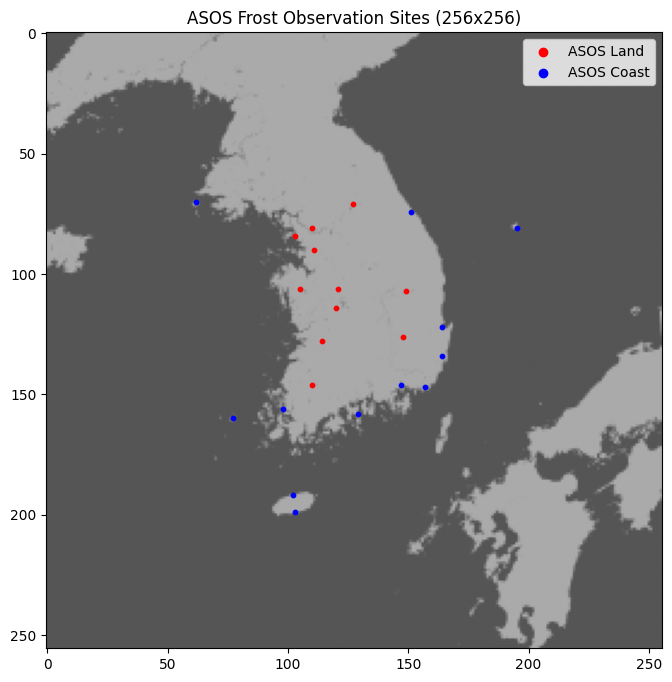

In [3]:
# get_station_map 함수를 사용하여 관측소 좌표 계산 (image_size에 따라 자동 변환)
# - image_size=512: 512 기준 좌표
# - image_size=384: 512에서 (64,64) offset으로 crop한 384x384 좌표
# - image_size=256: 512를 1/2로 resize한 좌표
# - image_size=192: 384 좌표를 2로 나눈 값
asos_map_dict = get_station_map(image_size, label_type='asos', origin_size=origin_size)

# Land와 Coast 관측소 분리 (시각화용)
asos_land_keys = list(ASOS_LAND_COORD.keys())
asos_coast_keys = list(ASOS_COAST_COORD.keys())
asos_land_map = {k: v for k, v in asos_map_dict.items() if k in asos_land_keys}
asos_coast_map = {k: v for k, v in asos_map_dict.items() if k in asos_coast_keys}

print(f"Image size: {image_size}")
print(f"ASOS station keys: {list(asos_map_dict.keys())}")

# ====== 좌표 유효성 검증 ======
print(f"\n=== 좌표 유효성 검증 ===")
all_coords = list(asos_map_dict.values())
xs = [c[0] for c in all_coords]
ys = [c[1] for c in all_coords]
print(f"X 범위: {min(xs)} ~ {max(xs)} (이미지: 0~{image_size-1})")
print(f"Y 범위: {min(ys)} ~ {max(ys)} (이미지: 0~{image_size-1})")

# 범위 밖 좌표 확인
out_of_bounds = [(k, v) for k, v in asos_map_dict.items() 
                 if not (0 <= v[0] < image_size and 0 <= v[1] < image_size)]
if out_of_bounds:
    print(f"Warning: 범위 밖 관측소: {out_of_bounds}")
else:
    print(f"All stations within image bounds.")

# === Soft coding: process_misc_image 함수 사용 ===
image = np.load('assets/misc_channels/watermap_1km_avg_3600.npy', allow_pickle=True)
image = -image + 1.0
image = process_misc_image(image, image_size, interpolation='cubic')

plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', vmin=-1, vmax=2)

for k, v in asos_land_map.items():
    plt.scatter(v[0], v[1], c='r', marker='o', s=10)
for k, v in asos_coast_map.items():
    plt.scatter(v[0], v[1], c='b', marker='o', s=10)

plt.scatter([], [], c='r', marker='o', label='ASOS Land')
plt.scatter([], [], c='b', marker='o', label='ASOS Coast')

plt.title(f'ASOS Frost Observation Sites ({image_size}x{image_size})')
plt.legend()
plt.show()

In [4]:
if channels_mean is None:
    date_list = os.listdir(data_path)
    date_list = [date for date in date_list if '20200101' <= date < '20240101']

    npy_list = []
    for date in tqdm(date_list[::10]):
        for file in os.listdir(os.path.join(data_path, date)):
            if channels not in file:
                continue
            npy = np.load(os.path.join(data_path, date, file), allow_pickle=True).astype(np.float32) # (C, H, W)
            npy_list.append(npy)
    npy_array = np.stack(npy_list, axis=0)
    print(npy_array.shape) # (N, C, H, W)

    channels_mean = npy_array.mean(axis=(0,2,3)).tolist()
    channels_std = npy_array.std(axis=(0,2,3)).tolist()

channels_mean = channels_mean * len(time_range)
channels_std = channels_std * len(time_range)

print(channels_mean)
print(channels_std)

[0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37]
[0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026]


In [5]:
lat_lon_data = nc.Dataset(lat_lon_path)
lat = lat_lon_data['lat'][:].data
lon = lat_lon_data['lon'][:].data

lat = cv2.resize(lat, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
lon = cv2.resize(lon, (origin_size, origin_size), interpolation=cv2.INTER_CUBIC)
print(lat.shape, lon.shape)

# === Soft coding: get_image_size_config 사용 ===
config = get_image_size_config(image_size)

# 512 기준 crop offset 계산
OFFSET_512 = (75, 115)  # asos 기준
base_512_x = (origin_size - 512) // 2 + OFFSET_512[0]
base_512_y = (origin_size - 512) // 2 + OFFSET_512[1]

if image_size == 512:
    # 512: origin_size에서 직접 crop
    asos_lat = lat[base_512_y:base_512_y+512, base_512_x:base_512_x+512].astype(np.float32)
    asos_lon = lon[base_512_y:base_512_y+512, base_512_x:base_512_x+512].astype(np.float32)
elif image_size == 256:
    # 256: 512 crop 후 resize
    asos_lat_512 = lat[base_512_y:base_512_y+512, base_512_x:base_512_x+512].astype(np.float32)
    asos_lon_512 = lon[base_512_y:base_512_y+512, base_512_x:base_512_x+512].astype(np.float32)
    asos_lat = cv2.resize(asos_lat_512, (256, 256), interpolation=cv2.INTER_AREA)
    asos_lon = cv2.resize(asos_lon_512, (256, 256), interpolation=cv2.INTER_AREA)
else:
    # 384, 192: 512에서 384 crop 후 필요시 resize
    crop_base = config['crop_base']
    crop_size = config['crop_size']
    
    # 384 영역 crop (origin_size 기준 좌표)
    lat_384_base_y = base_512_y + crop_base
    lat_384_base_x = base_512_x + crop_base
    asos_lat_384 = lat[lat_384_base_y:lat_384_base_y+crop_size, lat_384_base_x:lat_384_base_x+crop_size]
    asos_lon_384 = lon[lat_384_base_y:lat_384_base_y+crop_size, lat_384_base_x:lat_384_base_x+crop_size]
    
    # image_size에 따라 resize
    if config['resize_to'] is not None:
        asos_lat = cv2.resize(asos_lat_384.astype(np.float32), (image_size, image_size), interpolation=cv2.INTER_AREA)
        asos_lon = cv2.resize(asos_lon_384.astype(np.float32), (image_size, image_size), interpolation=cv2.INTER_AREA)
    else:
        asos_lat = asos_lat_384.astype(np.float32)
        asos_lon = asos_lon_384.astype(np.float32)

print(f'asos_lat shape: {asos_lat.shape}, asos_lon shape: {asos_lon.shape}')

lcc = ccrs.LambertConformal(central_longitude=126, central_latitude=38, standard_parallels = (30,60))
proj = ccrs.PlateCarree()

(900, 900) (900, 900)
asos_lat shape: (256, 256), asos_lon shape: (256, 256)


MISC images shape: torch.Size([3, 256, 256])
Total mean: [0.11912, 0.11464, 0.10734, 0.12504, 0.054983, 0.090381, 278.13, 237.2, 244.64, 251.3, 269.48, 248.9, 271.21, 270.71, 268.86, 257.37, 73.77144622802734, 0.13837116956710815, 0.748456597328186]
Total std: [0.1306, 0.1303, 0.1306, 0.1501, 0.0268, 0.0838, 15.8211, 6.1468, 7.8054, 9.3251, 16.4265, 9.615, 17.2518, 17.6064, 17.009, 12.5026, 190.70022583007812, 0.2716505229473114, 0.4236956536769867]


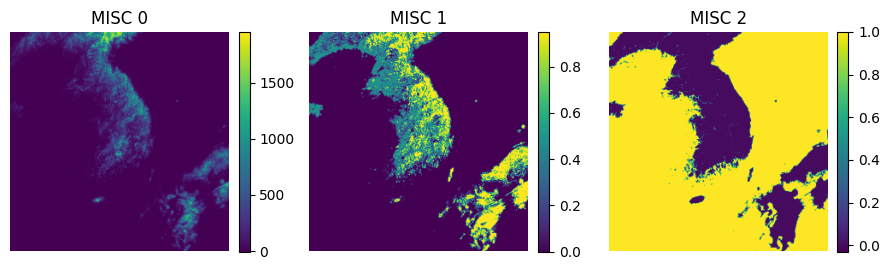

In [6]:
"""
MISC 0: Elevation (고도)
MISC 1: Water Bodies Index (수역 여부)
MISC 2: Vegetation Index (식생 여부)

처리 경로 (process_misc_image 함수 사용):
- 512: 3600 -> 512 resize
- 384: 3600 -> 512 resize -> 384 crop
- 256: 3600 -> 512 resize -> 256 resize
- 192: 3600 -> 512 resize -> 384 crop -> 192 resize
"""
misc_images = []
for misc_channel, misc_path in misc_channels.items():
    misc_image = np.load(f'assets/misc_channels/{misc_path}', allow_pickle=True)
    # === Soft coding: process_misc_image 함수 사용 ===
    misc_image = process_misc_image(misc_image, image_size, interpolation='cubic')
    misc_images.append(misc_image)

misc_images = np.stack(misc_images, axis=0)
misc_images = torch.tensor(misc_images, dtype=torch.float32)

if latlon:
    lat_image = torch.tensor(asos_lat, dtype=torch.float32).unsqueeze(0)
    lon_image = torch.tensor(asos_lon, dtype=torch.float32).unsqueeze(0)
    misc_images = torch.cat([misc_images, lat_image, lon_image], dim=0)

print(f'MISC images shape: {misc_images.shape}')

# normalize by channel
misc_mean = misc_images.mean(dim=[1,2], keepdim=True)
misc_std = misc_images.std(dim=[1,2], keepdim=True)

total_mean = channels_mean + misc_mean.squeeze().tolist()
total_std = channels_std + misc_std.squeeze().tolist()

print(f'Total mean: {total_mean}')
print(f'Total std: {total_std}')

fig, axs = plt.subplots(math.ceil(misc_images.shape[0]/3), 3, figsize=(9, 5))
for i in range(misc_images.shape[0]):
    ax = axs.flatten()[i]
    ax.imshow(misc_images[i].numpy(), cmap='viridis')
    ax.set_title(f'MISC {i}')
    colorbar = plt.colorbar(mappable=ax.images[0], ax=ax, fraction=0.046, pad=0.04)
    ax.axis('off')
for i in range(misc_images.shape[0], len(axs.flatten())):
    ax = axs.flatten()[i]
    ax.axis('off')
plt.tight_layout()
plt.show()

ASOS patch candidates shape: (1, 2)


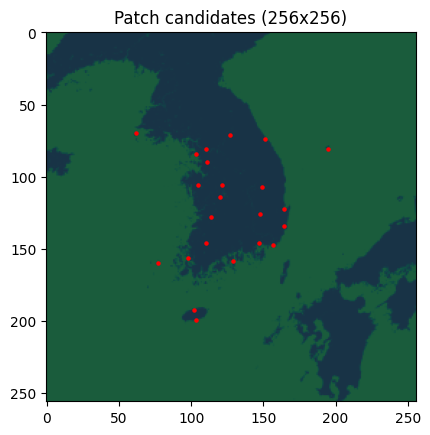

In [7]:
# patch_candidate 계산 - image_size와 patch_size가 같으면 전체 이미지 사용
asos_patch_candidate = np.zeros([image_size, image_size], dtype=np.uint8)

for x, y in asos_map_dict.values():
    # 좌표가 범위 내인지 확인
    if 0 <= x < image_size and 0 <= y < image_size:
        y_min = np.clip(y - 3*patch_size//4, 0, max(0, image_size - patch_size + 1))
        y_max = np.clip(y - patch_size//4, 0, max(0, image_size - patch_size + 1))
        x_min = np.clip(x - 3*patch_size//4, 0, max(0, image_size - patch_size + 1))
        x_max = np.clip(x - patch_size//4, 0, max(0, image_size - patch_size + 1))
        
        if y_min < y_max and x_min < x_max:
            asos_patch_candidate[y_min:y_max, x_min:x_max] = 1
        plt.scatter(x, y, c='r', marker='o', s=5)

plt.imshow(misc_images[2], cmap='viridis', vmin=-1, vmax=2)
if asos_patch_candidate.sum() > 0:
    plt.imshow(asos_patch_candidate, cmap='gray', vmin=0, vmax=1, alpha=0.5)
    
asos_patch_candidate = np.argwhere(asos_patch_candidate == 1)[:, [1, 0]]
print(f'ASOS patch candidates shape: {asos_patch_candidate.shape}')
plt.title(f'Patch candidates ({image_size}x{image_size})')
plt.show()

patch_candidates = {
    'asos': asos_patch_candidate
}

Sample image shape: (16, 256, 256)


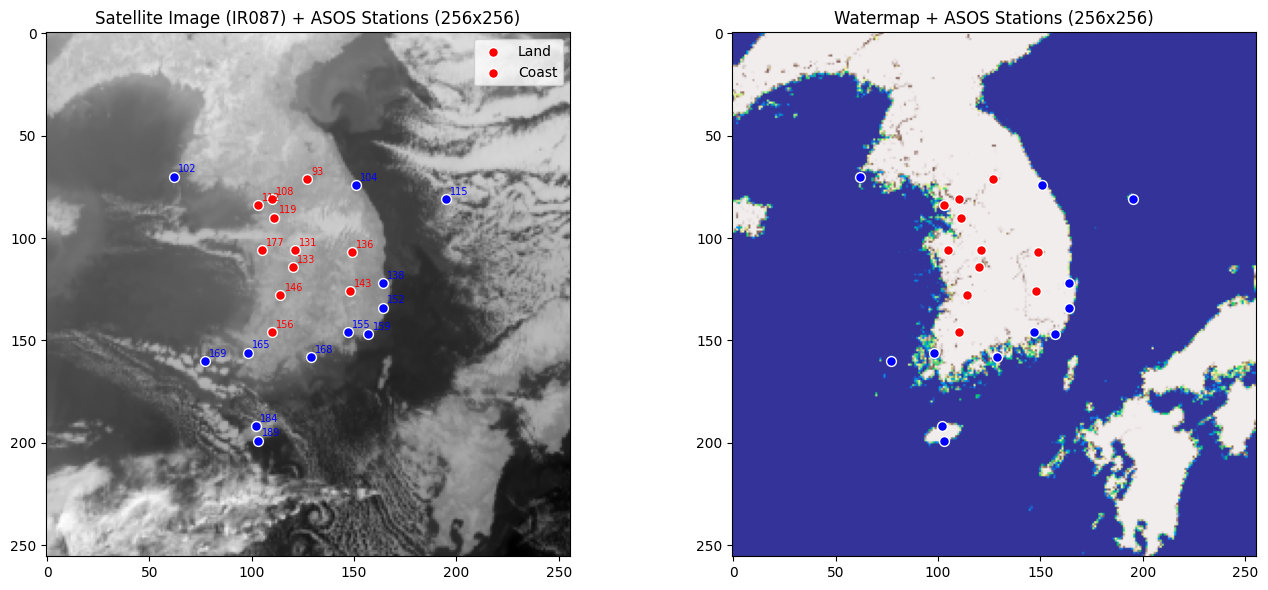


=== ASOS 좌표 범위 검증 (256x256) ===
X 범위: 62 ~ 195 (이미지: 0~255)
Y 범위: 70 ~ 199 (이미지: 0~255)
범위 내 관측소: 23/23


In [8]:
# === 이미지 + ASOS 좌표 시각적 검증 ===
import numpy as np
import matplotlib.pyplot as plt

# 1. 샘플 위성 이미지 로드
sample_date = '20230101'
sample_file = f'{data_path}/{sample_date}/16ch_{sample_date}0600.npy'
sample_image = np.load(sample_file).astype(np.float32)

# === Soft coding: process_image_for_size 함수 사용 ===
sample_image = process_image_for_size(sample_image, image_size, interpolation='area')

print(f"Sample image shape: {sample_image.shape}")

# 2. IR 채널로 배경 표시
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 좌: 위성 이미지 + ASOS 위치
ax1 = axes[0]
ax1.imshow(sample_image[10], cmap='gray')  # IR087 채널
for k, (x, y) in asos_land_map.items():
    ax1.scatter(x, y, c='red', s=50, edgecolors='white', linewidth=1)
    ax1.annotate(str(k), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=7, color='red')
for k, (x, y) in asos_coast_map.items():
    ax1.scatter(x, y, c='blue', s=50, edgecolors='white', linewidth=1)
    ax1.annotate(str(k), (x, y), xytext=(3, 3), textcoords='offset points', 
                fontsize=7, color='blue')
ax1.set_title(f'Satellite Image (IR087) + ASOS Stations ({image_size}x{image_size})')
ax1.legend(['Land', 'Coast'], loc='upper right')

# 우: 지형 맵(watermap) + ASOS 위치
ax2 = axes[1]
watermap = misc_images[2].numpy() if torch.is_tensor(misc_images[2]) else misc_images[2]
ax2.imshow(-watermap + 1, cmap='terrain')
for k, (x, y) in asos_land_map.items():
    ax2.scatter(x, y, c='red', s=50, edgecolors='white', linewidth=1)
for k, (x, y) in asos_coast_map.items():
    ax2.scatter(x, y, c='blue', s=50, edgecolors='white', linewidth=1)
ax2.set_title(f'Watermap + ASOS Stations ({image_size}x{image_size})')

plt.tight_layout()
plt.show()

# 3. 좌표 범위 검증 출력
print(f"\n=== ASOS 좌표 범위 검증 ({image_size}x{image_size}) ===")
all_coords = list(asos_land_map.values()) + list(asos_coast_map.values())
xs = [c[0] for c in all_coords]
ys = [c[1] for c in all_coords]
print(f"X 범위: {min(xs)} ~ {max(xs)} (이미지: 0~{image_size-1})")
print(f"Y 범위: {min(ys)} ~ {max(ys)} (이미지: 0~{image_size-1})")
print(f"범위 내 관측소: {sum(1 for x,y in all_coords if 0<=x<image_size and 0<=y<image_size)}/23")

In [9]:
print(f"image_size: {image_size}, patch_size: {patch_size}")

transform = transforms.Compose([
    transforms.Normalize(mean=total_mean, std=total_std)
])

train_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=train_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=patch_candidates, transform=transform, train=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

if ASOS:
    test_asos_dataset = GK2ADataset(data_path=data_path, output_path=output_path, data_info_list=test_asos_data_info_list,
                            channels=channels, time_range=time_range, channels_calib=channels_calib, image_size=image_size, misc_images=misc_images,
                            patch_size=patch_size, patch_candidates=None, transform=transform, train=False)
    test_asos_dataloader = DataLoader(test_asos_dataset, batch_size=batch_size//2, shuffle=False, num_workers=num_workers, drop_last=False)

image_size: 256, patch_size: 256
== Preparing asos...



Processing asos:   1%|▌                                          | 15/1277 [00:00<00:08, 141.25it/s]

  - 20200101 AM skipped, 2019-12-31 18:00:00 not in date_table


Processing asos:  51%|█████████████████████▌                    | 655/1277 [00:02<00:01, 446.69it/s]

  - 20211003 AM skipped, 2021-10-02 18:00:00 not in date_table


Processing asos: 100%|█████████████████████████████████████████| 1277/1277 [00:05<00:00, 244.65it/s]



  - Total 1275 image-label pairs prepared
  - train_asos_image_label_list.yaml saved

== asos dataset length synced to 1275
GK2A Dataset initialized


== Preparing asos...



Processing asos: 100%|███████████████████████████████████████████| 366/366 [00:01<00:00, 247.56it/s]



  - Total 366 image-label pairs prepared
  - test_asos_image_label_list.yaml saved

== asos dataset length synced to 366
GK2A Dataset initialized




Dataset patchfy set to True.

images.shape: torch.Size([1, 19, 256, 256]), label.shape: torch.Size([23]), coords.shape: (2,)
After squeeze - images.shape: torch.Size([19, 256, 256])


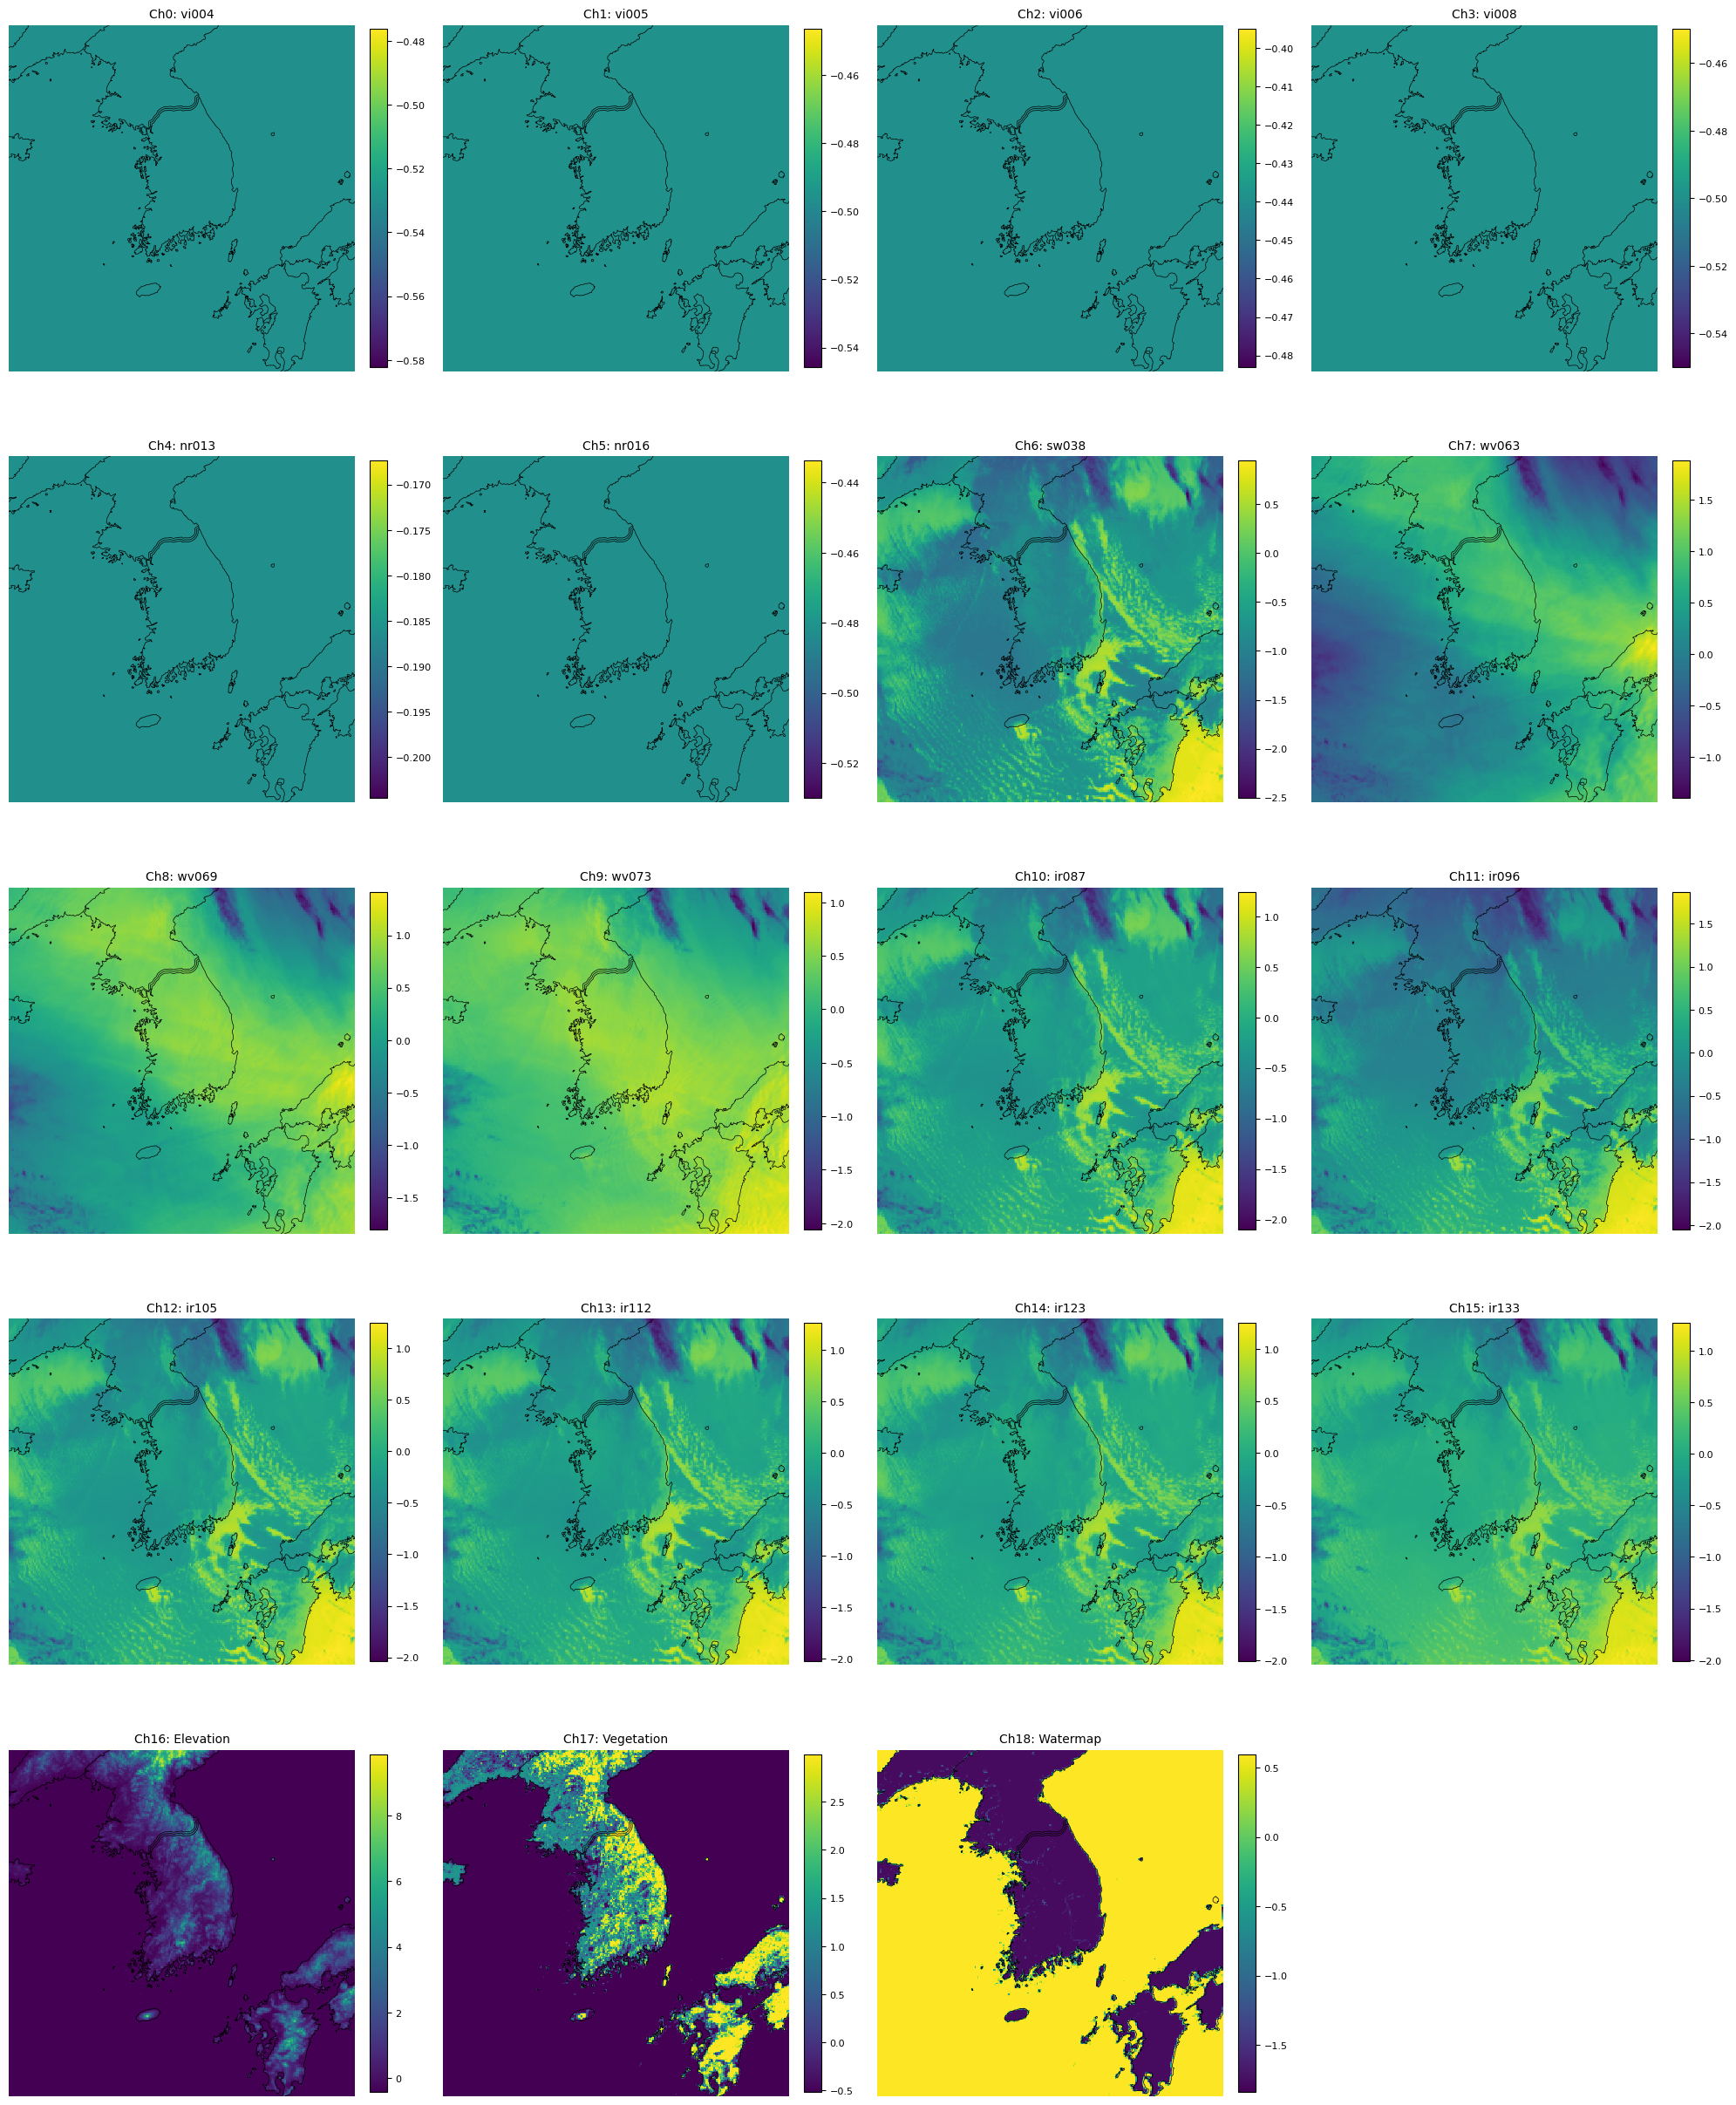

Visualized 19 channels total


In [10]:
train_dataset.patchfy(True)
batch = train_dataset[7]
for i in range(len(batch)):
    images, label, coords = batch[i]
    print(f"images.shape: {images.shape}, label.shape: {label.shape}, coords.shape: {coords.shape}")

    # images는 (B, C, H, W) 형태 - 배치 차원 제거
    if images.ndim == 4:
        images = images.squeeze(0)  # (1, 19, 192, 192) -> (19, 192, 192)
    
    print(f"After squeeze - images.shape: {images.shape}")
    
    # 모든 채널 시각화
    num_channels = images.shape[0]
    
    # 그리드 레이아웃 계산 (4열로 배치)
    cols = 4
    rows = math.ceil(num_channels / cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), subplot_kw={'projection': lcc})
    
    # axs를 항상 1D 배열로 변환
    if rows == 1 and cols == 1:
        axs = np.array([axs])
    elif rows == 1 or cols == 1:
        axs = axs.flatten()
    else:
        axs = axs.flatten()

    for j in range(len(axs)):
        ax = axs[j]
        
        if j >= num_channels:
            # 채널 수보다 많은 subplot은 숨김
            ax.axis('off')
            continue

        img = np.ones((image_size, image_size), dtype=np.float32)
        img *= -1.0
        
        # coords가 패치 시작점
        py, px = int(coords[1]), int(coords[0])
        
        # j번째 채널 선택
        patch_data = images[j]
        
        # torch tensor를 numpy로 변환
        if torch.is_tensor(patch_data):
            patch_data = patch_data.numpy()
        
        # 3D 배열이면 2D로 변환
        while patch_data.ndim > 2:
            if patch_data.shape[0] == 1:
                patch_data = patch_data.squeeze(0)
            else:
                patch_data = patch_data[0]
        
        # 2D가 아니면 건너뛰기
        if patch_data.ndim != 2:
            print(f"ERROR: Channel {j} has {patch_data.ndim} dimensions, skipping")
            ax.axis('off')
            continue
        
        patch_h, patch_w = patch_data.shape
        img[py:py+patch_h, px:px+patch_w] = patch_data

        ax.set_aspect('equal')
        ax.axis('off')
        
        # 채널 이름 표시 (16개 위성 채널 + 3개 misc 채널)
        if j < len(channels_name):
            channel_title = f'Ch{j}: {channels_name[j]}'
        elif j < len(channels_name) * len(time_range):
            channel_title = f'Ch{j}: Time offset'
        else:
            misc_idx = j - len(channels_name) * len(time_range)
            misc_names = ['Elevation', 'Vegetation', 'Watermap']
            if misc_idx < len(misc_names):
                channel_title = f'Ch{j}: {misc_names[misc_idx]}'
            else:
                channel_title = f'Ch{j}: Misc'
        
        ax.set_title(channel_title, fontsize=10)
        
        im = ax.pcolormesh(asos_lon, asos_lat, img, cmap='viridis', transform=proj)
            
        ax.coastlines(resolution='10m', color='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS.with_scale('10m'), edgecolor='black', linewidth=0.5)

        # colorbar 크기 조정
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink=0.8)
        cbar.ax.tick_params(labelsize=8)
        
    plt.tight_layout()
    plt.show()
    
    print(f"Visualized {num_channels} channels total")

In [11]:
model = get_model(total_channels, patch_size, class_num=2)
model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(19, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [12]:
def calc_measure_valid(Y_test, Y_test_hat, cutoff=0.5):
    Y_test = Y_test.ravel()
    Y_test_hat = Y_test_hat.ravel()
    
    Y_valid = (~np.isnan(Y_test))
    Y_test = Y_test[Y_valid]
    Y_test_hat = Y_test_hat[Y_valid]

    cfmat = confusion_matrix(Y_test, Y_test_hat > cutoff, labels = [0,1])
    acc = np.trace(cfmat) / np.sum(cfmat)
    csi = cfmat[1,1] /(np.sum(cfmat) - cfmat[0,0] + 1e-8)
    
    try:
        auroc = roc_auc_score(Y_test, Y_test_hat)
    except Exception as e:
        auroc = 0.0

    return csi, acc, auroc

In [13]:
def train(model, images, labels, coords, map_dict, cls_num=0):
    # images 차원 확인 및 수정: [B, 1, C, H, W] -> [B, C, H, W]
    if images.ndim == 5 and images.shape[1] == 1:
        images = images.squeeze(1)
    
    images = images.cuda()
    labels = labels.cuda()

    pred_map = model.forward(images)[:, cls_num] # B, H, W
    pred_vec = torch.zeros_like(labels)
    for b, (px, py) in enumerate(coords):
        for i, (x, y) in enumerate(map_dict.values()):
            # patch_size가 image_size와 같으면 항상 범위 내
            if px <= x < px + patch_size and py <= y < py + patch_size:
                pred_vec[b, i] = pred_map[b, y - py, x - px]
            else:
                pred_vec[b, i] = labels[b, i]

    labels_valid = (~torch.isnan(labels)).float()
    labels = torch.nan_to_num(labels, 0.0)

    loss_focal_raw = sigmoid_focal_loss(pred_vec, labels, alpha=-1, gamma=2, reduction='none')
    loss_focal = (loss_focal_raw * labels_valid).sum() / labels_valid.sum().clamp(min=1.0)
    valid_any_batch = (labels_valid.sum() > 0)
    all_zero_batch = ((labels * labels_valid).sum() == 0)
                
    if not (valid_any_batch and all_zero_batch):
        loss_non_frost = torch.tensor(0.0, device=labels.device)
    else:
        loss_non_frost = binary_cross_entropy_with_logits(
                        pred_map, torch.zeros_like(pred_map), reduction='mean'
                    )

    tp = torch.sum(torch.sigmoid(pred_vec) * labels * labels_valid, dim=0)
    fn = torch.sum((1-torch.sigmoid(pred_vec)) * labels * labels_valid, dim=0)
    fp = torch.sum(torch.sigmoid(pred_vec) * (1-labels) * labels_valid, dim=0)
                
    loss_csi = torch.mean(-torch.log(tp + 1e-10) + torch.log(tp + fn + fp + 1e-10)) # csi = tp / (tp + fn + fp)

    return loss_focal + loss_non_frost + loss_csi
    

for seed in seeds:
    if os.path.exists(f'{output_path}/{seed}/ckpt.pt'):
        print(f'Seed {seed} already done. Skipping...')
        continue
    
    model = get_model(total_channels, patch_size)
    model.cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay, gamma=lr_decay)

    start_epoch = 0
    
    results = dict(
            loss = {'asos': [], 'aafos': [], 'total': []},
            csi = {'asos': {}, 'aafos': {}},
            acc = {'asos': {}, 'aafos': {}},
            auroc = {'asos': [], 'aafos': []}, 
            
            best_asos = {},
            best_aafos = {},
            best_mean = {},
        )
    
    for cutoff_str in threshold:
        cutoff_str = str(cutoff_str)
        
        results['csi']['asos'][cutoff_str] = []
        results['acc']['asos'][cutoff_str] = []
        results['best_asos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['csi']['aafos'][cutoff_str] = []
        results['acc']['aafos'][cutoff_str] = []
        results['best_aafos'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
        
        results['best_mean'][cutoff_str] = {'csi': 0.0, 'epoch': -1, 'model': None}
    
    if os.path.exists(f'{output_path}/{seed}/resume.pt'):
        resume = torch.load(f'{output_path}/{seed}/resume.pt')
        model.load_state_dict(resume['model'])
        optimizer.load_state_dict(resume['optimizer'])
        scheduler.load_state_dict(resume['scheduler'])
        start_epoch = resume['epoch'] + 1
        results = resume['results']
        print(f'Resuming from epoch {start_epoch}...')
    
    for epoch in range(start_epoch, epochs):
        model.train()
        
        total_loss_asos = 0.0
        total_loss_aafos = 0.0
        total_loss = 0.0
                
        # asos와 aafos 데이터셋 간 길이 맞춤 / 매 epoch마다 실행
        train_dataset.sync_dataset_length()
        for batch in tqdm(train_dataloader):
            if ASOS:
                images, label, coords = batch[0]
                loss_asos = train(model, images, label, coords, asos_map_dict, cls_num=0)
            else:
                loss_asos = torch.tensor(0.0).cuda()
            
            if AAFOS:
                images, label, coords = batch[1] if ASOS else batch[0]
                loss_aafos = train(model, images, label, coords, aafos_map_dict, cls_num=1)
            else:
                loss_aafos = torch.tensor(0.0).cuda()

            loss = asos_weight * loss_asos + aafos_weight * loss_aafos
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss_asos += loss_asos.item()
            total_loss_aafos += loss_aafos.item()
            total_loss += loss.item()

        total_loss_asos = total_loss_asos / len(train_dataloader)
        total_loss_aafos = total_loss_aafos / len(train_dataloader)
        total_loss = total_loss / len(train_dataloader)

        results['loss']['asos'].append(total_loss_asos)
        results['loss']['aafos'].append(total_loss_aafos)
        results['loss']['total'].append(total_loss)

        print(f'Epoch {epoch:2d} - Total Loss: {total_loss:.4f}, ASOS Loss: {total_loss_asos:.4f}, AAFOS Loss: {total_loss_aafos:.4f}')
        scheduler.step()
    
        model.eval()
        with torch.no_grad():
            asos_results_per_threshold = {}
            
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []
                for batch in test_asos_dataloader:
                    images, label, coords = batch[0]
                    
                    # 평가 시에도 차원 수정
                    if images.ndim == 5 and images.shape[1] == 1:
                        images = images.squeeze(1)
                    
                    images = images.cuda()
                    
                    pred_map = model.forward_by_patch(images)[:,0]
                    pred_map = F.sigmoid(pred_map)
                    
                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        # 좌표가 pred_map 범위 내인지 확인
                        if 0 <= y < pred_map.shape[1] and 0 <= x < pred_map.shape[2]:
                            pred_vec.append(pred_map[:, y, x])
                        else:
                            # 범위 밖이면 0으로 처리
                            print(f"Warning: coord ({x}, {y}) out of pred_map bounds {pred_map.shape[1:]}")
                            pred_vec.append(torch.zeros(pred_map.shape[0], device=pred_map.device))
                    pred_vec = torch.stack(pred_vec, dim=1)
                    
                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())
                    
                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)
                
                for cutoff in threshold:
                    asos_result = calc_measure_valid(labels, pred_vecs, cutoff=cutoff)
                    csi, acc, auroc = asos_result[0], asos_result[1], asos_result[2]

                    cutoff_str = str(cutoff)
                    
                    results['csi']['asos'][cutoff_str].append(csi)
                    results['acc']['asos'][cutoff_str].append(acc)
                    
                    asos_results_per_threshold[cutoff_str] = asos_result
                    
                    is_best = csi > results['best_asos'][cutoff_str]['csi']
                    print(f'\t - ASOS  (T={cutoff:.2f}): CSI {csi:.4f}, AUROC {auroc:.4f} {"*" if is_best else ""}')
                    
                    if is_best:
                        results['best_asos'][cutoff_str]['csi'] = csi
                        results['best_asos'][cutoff_str]['epoch'] = epoch
                        results['best_asos'][cutoff_str]['model'] = model.state_dict()

                    asos_land_result = calc_measure_valid(labels[:,:11], pred_vecs[:,:11], cutoff=cutoff)
                    asos_coast_result = calc_measure_valid(labels[:,11:], pred_vecs[:,11:], cutoff=cutoff)
                    print(f'\t   - ASOS Land: CSI {asos_land_result[0]:.4f}, AUROC {asos_land_result[2]:.4f}')
                    print(f'\t   - ASOS Coast: CSI {asos_coast_result[0]:.4f}, AUROC {asos_coast_result[2]:.4f}')

                    log_dir = f'{output_path}/{seed}'
                    log_path = f'{log_dir}/train_log.csv'
                    
                    os.makedirs(log_dir, exist_ok=True)
                    
                    is_first_write = not os.path.exists(log_path)
                    
                    with open(log_path, 'a') as log_f:
                        if is_first_write:
                            log_f.write('Epoch,Threshold,ASOS_Loss,CSI,AUROC,Land_CSI,Coast_CSI\n')
                        
                        log_line = (f'{epoch},{cutoff},{total_loss_asos:.6f},{csi:.6f},{auroc:.6f},'
                                    f'{asos_land_result[0]:.6f},{asos_coast_result[0]:.6f}\n')
                        log_f.write(log_line)

                results['auroc']['asos'].append(auroc)
                            
            print()
        
        resume = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'epoch': epoch,
            'results': results
        }
        os.makedirs(f'{output_path}/{seed}', exist_ok=True)
        torch.save(resume, f'{output_path}/{seed}/resume.pt')
    
    torch.save(results, f'{output_path}/{seed}/ckpt.pt')
    os.remove(f'{output_path}/{seed}/resume.pt')

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.10s/it]

Epoch  0 - Total Loss: 5.8888, ASOS Loss: 5.8888, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4087, AUROC 0.9377 *
	   - ASOS Land: CSI 0.4634, AUROC 0.9300
	   - ASOS Coast: CSI 0.2716, AUROC 0.9148

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  1 - Total Loss: 4.2637, ASOS Loss: 4.2637, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4235, AUROC 0.9143 *
	   - ASOS Land: CSI 0.5034, AUROC 0.9185
	   - ASOS Coast: CSI 0.1604, AUROC 0.8683

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:21<00:00,  1.12s/it]

Epoch  2 - Total Loss: 3.4465, ASOS Loss: 3.4465, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4189, AUROC 0.9492 
	   - ASOS Land: CSI 0.4885, AUROC 0.9463
	   - ASOS Coast: CSI 0.2727, AUROC 0.9283

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  3 - Total Loss: 3.4573, ASOS Loss: 3.4573, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4457, AUROC 0.9493 *
	   - ASOS Land: CSI 0.5363, AUROC 0.9493
	   - ASOS Coast: CSI 0.2715, AUROC 0.9301

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  4 - Total Loss: 3.7395, ASOS Loss: 3.7395, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5229, AUROC 0.9560 *
	   - ASOS Land: CSI 0.5942, AUROC 0.9561
	   - ASOS Coast: CSI 0.3350, AUROC 0.9310

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:21<00:00,  1.11s/it]

Epoch  5 - Total Loss: 3.6483, ASOS Loss: 3.6483, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5087, AUROC 0.9513 
	   - ASOS Land: CSI 0.5878, AUROC 0.9539
	   - ASOS Coast: CSI 0.3327, AUROC 0.9232

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  6 - Total Loss: 3.2776, ASOS Loss: 3.2776, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5328, AUROC 0.9441 *
	   - ASOS Land: CSI 0.5904, AUROC 0.9459
	   - ASOS Coast: CSI 0.3671, AUROC 0.9117

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  7 - Total Loss: 3.5016, ASOS Loss: 3.5016, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3352, AUROC 0.9472 
	   - ASOS Land: CSI 0.4061, AUROC 0.9530
	   - ASOS Coast: CSI 0.2044, AUROC 0.9149

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  8 - Total Loss: 3.6493, ASOS Loss: 3.6493, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3979, AUROC 0.9499 
	   - ASOS Land: CSI 0.4696, AUROC 0.9540
	   - ASOS Coast: CSI 0.2530, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  9 - Total Loss: 3.6242, ASOS Loss: 3.6242, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4797, AUROC 0.9503 
	   - ASOS Land: CSI 0.5452, AUROC 0.9509
	   - ASOS Coast: CSI 0.3221, AUROC 0.9244

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]

Epoch 10 - Total Loss: 3.5824, ASOS Loss: 3.5824, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5283, AUROC 0.9527 
	   - ASOS Land: CSI 0.5900, AUROC 0.9558
	   - ASOS Coast: CSI 0.3549, AUROC 0.9229

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 11 - Total Loss: 3.4842, ASOS Loss: 3.4842, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5336, AUROC 0.9529 *
	   - ASOS Land: CSI 0.5941, AUROC 0.9566
	   - ASOS Coast: CSI 0.3648, AUROC 0.9218

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 12 - Total Loss: 3.3064, ASOS Loss: 3.3064, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5389, AUROC 0.9516 *
	   - ASOS Land: CSI 0.6026, AUROC 0.9569
	   - ASOS Coast: CSI 0.3344, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 13 - Total Loss: 3.1541, ASOS Loss: 3.1541, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5131, AUROC 0.9540 
	   - ASOS Land: CSI 0.5829, AUROC 0.9592
	   - ASOS Coast: CSI 0.3391, AUROC 0.9203

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 14 - Total Loss: 3.1854, ASOS Loss: 3.1854, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5377, AUROC 0.9509 
	   - ASOS Land: CSI 0.6039, AUROC 0.9553
	   - ASOS Coast: CSI 0.3170, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.10s/it]

Epoch 15 - Total Loss: 3.3975, ASOS Loss: 3.3975, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5358, AUROC 0.9515 
	   - ASOS Land: CSI 0.5954, AUROC 0.9561
	   - ASOS Coast: CSI 0.3783, AUROC 0.9173

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 16 - Total Loss: 2.9629, ASOS Loss: 2.9629, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5358, AUROC 0.9531 
	   - ASOS Land: CSI 0.5976, AUROC 0.9579
	   - ASOS Coast: CSI 0.3650, AUROC 0.9179

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 17 - Total Loss: 3.0643, ASOS Loss: 3.0643, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5351, AUROC 0.9504 
	   - ASOS Land: CSI 0.5902, AUROC 0.9543
	   - ASOS Coast: CSI 0.3505, AUROC 0.9155

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 18 - Total Loss: 3.2299, ASOS Loss: 3.2299, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5308, AUROC 0.9495 
	   - ASOS Land: CSI 0.5914, AUROC 0.9541
	   - ASOS Coast: CSI 0.3710, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 19 - Total Loss: 2.8245, ASOS Loss: 2.8245, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5377, AUROC 0.9508 
	   - ASOS Land: CSI 0.5985, AUROC 0.9561
	   - ASOS Coast: CSI 0.3385, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.06s/it]

Epoch 20 - Total Loss: 3.3807, ASOS Loss: 3.3807, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5403, AUROC 0.9518 *
	   - ASOS Land: CSI 0.5965, AUROC 0.9568
	   - ASOS Coast: CSI 0.3601, AUROC 0.9170

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.06s/it]

Epoch 21 - Total Loss: 2.8785, ASOS Loss: 2.8785, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5382, AUROC 0.9513 
	   - ASOS Land: CSI 0.5961, AUROC 0.9560
	   - ASOS Coast: CSI 0.3522, AUROC 0.9165

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 22 - Total Loss: 3.0443, ASOS Loss: 3.0443, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5364, AUROC 0.9513 
	   - ASOS Land: CSI 0.5945, AUROC 0.9560
	   - ASOS Coast: CSI 0.3536, AUROC 0.9168

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 23 - Total Loss: 2.6109, ASOS Loss: 2.6109, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5375, AUROC 0.9504 
	   - ASOS Land: CSI 0.5947, AUROC 0.9550
	   - ASOS Coast: CSI 0.3552, AUROC 0.9161

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 24 - Total Loss: 2.8943, ASOS Loss: 2.8943, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5380, AUROC 0.9500 
	   - ASOS Land: CSI 0.5935, AUROC 0.9545
	   - ASOS Coast: CSI 0.3549, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  0 - Total Loss: 5.6654, ASOS Loss: 5.6654, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4030, AUROC 0.9215 *
	   - ASOS Land: CSI 0.4463, AUROC 0.9170
	   - ASOS Coast: CSI 0.2282, AUROC 0.8960

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  1 - Total Loss: 4.0908, ASOS Loss: 4.0908, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4166, AUROC 0.9312 *
	   - ASOS Land: CSI 0.4625, AUROC 0.9244
	   - ASOS Coast: CSI 0.2355, AUROC 0.8977

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.10s/it]

Epoch  2 - Total Loss: 3.3437, ASOS Loss: 3.3437, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4294, AUROC 0.9557 *
	   - ASOS Land: CSI 0.5067, AUROC 0.9566
	   - ASOS Coast: CSI 0.2729, AUROC 0.9307

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  3 - Total Loss: 3.4278, ASOS Loss: 3.4278, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5157, AUROC 0.9531 *
	   - ASOS Land: CSI 0.5803, AUROC 0.9491
	   - ASOS Coast: CSI 0.3371, AUROC 0.9347

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  4 - Total Loss: 3.7436, ASOS Loss: 3.7436, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4311, AUROC 0.9540 
	   - ASOS Land: CSI 0.5204, AUROC 0.9547
	   - ASOS Coast: CSI 0.2601, AUROC 0.9297

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:21<00:00,  1.11s/it]

Epoch  5 - Total Loss: 3.9833, ASOS Loss: 3.9833, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.1068, AUROC 0.9286 
	   - ASOS Land: CSI 0.1385, AUROC 0.9200
	   - ASOS Coast: CSI 0.0000, AUROC 0.9092

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  6 - Total Loss: 3.5751, ASOS Loss: 3.5751, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5004, AUROC 0.9479 
	   - ASOS Land: CSI 0.5754, AUROC 0.9478
	   - ASOS Coast: CSI 0.2888, AUROC 0.9235

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  7 - Total Loss: 3.6100, ASOS Loss: 3.6100, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5508, AUROC 0.9539 *
	   - ASOS Land: CSI 0.6121, AUROC 0.9545
	   - ASOS Coast: CSI 0.3673, AUROC 0.9267

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  8 - Total Loss: 3.9707, ASOS Loss: 3.9707, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4889, AUROC 0.9417 
	   - ASOS Land: CSI 0.5471, AUROC 0.9429
	   - ASOS Coast: CSI 0.3055, AUROC 0.9052

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  9 - Total Loss: 3.7239, ASOS Loss: 3.7239, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4508, AUROC 0.9519 
	   - ASOS Land: CSI 0.5239, AUROC 0.9556
	   - ASOS Coast: CSI 0.2835, AUROC 0.9183

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 10 - Total Loss: 3.1086, ASOS Loss: 3.1086, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5440, AUROC 0.9512 
	   - ASOS Land: CSI 0.6073, AUROC 0.9549
	   - ASOS Coast: CSI 0.3711, AUROC 0.9186

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 11 - Total Loss: 3.4056, ASOS Loss: 3.4056, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5443, AUROC 0.9505 
	   - ASOS Land: CSI 0.6125, AUROC 0.9548
	   - ASOS Coast: CSI 0.3364, AUROC 0.9171

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 12 - Total Loss: 3.3921, ASOS Loss: 3.3921, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5365, AUROC 0.9500 
	   - ASOS Land: CSI 0.5996, AUROC 0.9540
	   - ASOS Coast: CSI 0.3430, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 13 - Total Loss: 3.0713, ASOS Loss: 3.0713, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5204, AUROC 0.9496 
	   - ASOS Land: CSI 0.5779, AUROC 0.9529
	   - ASOS Coast: CSI 0.3549, AUROC 0.9156

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]

Epoch 14 - Total Loss: 3.1078, ASOS Loss: 3.1078, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5341, AUROC 0.9491 
	   - ASOS Land: CSI 0.5913, AUROC 0.9530
	   - ASOS Coast: CSI 0.3505, AUROC 0.9140

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 15 - Total Loss: 3.2906, ASOS Loss: 3.2906, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5295, AUROC 0.9480 
	   - ASOS Land: CSI 0.5901, AUROC 0.9529
	   - ASOS Coast: CSI 0.3499, AUROC 0.9106

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 16 - Total Loss: 3.0898, ASOS Loss: 3.0898, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5342, AUROC 0.9486 
	   - ASOS Land: CSI 0.5912, AUROC 0.9523
	   - ASOS Coast: CSI 0.3526, AUROC 0.9130

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 17 - Total Loss: 3.1246, ASOS Loss: 3.1246, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5219, AUROC 0.9483 
	   - ASOS Land: CSI 0.5808, AUROC 0.9517
	   - ASOS Coast: CSI 0.3225, AUROC 0.9129

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:21<00:00,  1.12s/it]

Epoch 18 - Total Loss: 2.9660, ASOS Loss: 2.9660, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5338, AUROC 0.9494 
	   - ASOS Land: CSI 0.5936, AUROC 0.9540
	   - ASOS Coast: CSI 0.3322, AUROC 0.9139

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 19 - Total Loss: 3.0097, ASOS Loss: 3.0097, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5234, AUROC 0.9491 
	   - ASOS Land: CSI 0.5816, AUROC 0.9531
	   - ASOS Coast: CSI 0.3302, AUROC 0.9136

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 20 - Total Loss: 3.2210, ASOS Loss: 3.2210, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5327, AUROC 0.9495 
	   - ASOS Land: CSI 0.5878, AUROC 0.9532
	   - ASOS Coast: CSI 0.3652, AUROC 0.9155

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 21 - Total Loss: 2.8788, ASOS Loss: 2.8788, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5267, AUROC 0.9492 
	   - ASOS Land: CSI 0.5877, AUROC 0.9533
	   - ASOS Coast: CSI 0.3333, AUROC 0.9143

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 22 - Total Loss: 2.7551, ASOS Loss: 2.7551, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5260, AUROC 0.9494 
	   - ASOS Land: CSI 0.5872, AUROC 0.9532
	   - ASOS Coast: CSI 0.3282, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 23 - Total Loss: 2.8510, ASOS Loss: 2.8510, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5277, AUROC 0.9496 
	   - ASOS Land: CSI 0.5832, AUROC 0.9530
	   - ASOS Coast: CSI 0.3514, AUROC 0.9160

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 24 - Total Loss: 2.5971, ASOS Loss: 2.5971, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5280, AUROC 0.9493 
	   - ASOS Land: CSI 0.5867, AUROC 0.9525
	   - ASOS Coast: CSI 0.3375, AUROC 0.9159

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  0 - Total Loss: 5.6727, ASOS Loss: 5.6727, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.2826, AUROC 0.9363 *
	   - ASOS Land: CSI 0.3805, AUROC 0.9408
	   - ASOS Coast: CSI 0.1487, AUROC 0.9032

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  1 - Total Loss: 4.3406, ASOS Loss: 4.3406, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.2649, AUROC 0.9417 
	   - ASOS Land: CSI 0.3234, AUROC 0.9360
	   - ASOS Coast: CSI 0.1604, AUROC 0.9144

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  2 - Total Loss: 3.8305, ASOS Loss: 3.8305, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.3828, AUROC 0.9480 *
	   - ASOS Land: CSI 0.4318, AUROC 0.9494
	   - ASOS Coast: CSI 0.2667, AUROC 0.9203

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  3 - Total Loss: 3.7039, ASOS Loss: 3.7039, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5012, AUROC 0.9542 *
	   - ASOS Land: CSI 0.5699, AUROC 0.9560
	   - ASOS Coast: CSI 0.3215, AUROC 0.9225

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch  4 - Total Loss: 3.4722, ASOS Loss: 3.4722, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5107, AUROC 0.9561 *
	   - ASOS Land: CSI 0.5870, AUROC 0.9581
	   - ASOS Coast: CSI 0.3276, AUROC 0.9275

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]

Epoch  5 - Total Loss: 3.0426, ASOS Loss: 3.0426, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4543, AUROC 0.9530 
	   - ASOS Land: CSI 0.5357, AUROC 0.9573
	   - ASOS Coast: CSI 0.2818, AUROC 0.9210

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  6 - Total Loss: 3.3707, ASOS Loss: 3.3707, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5146, AUROC 0.9543 *
	   - ASOS Land: CSI 0.5820, AUROC 0.9583
	   - ASOS Coast: CSI 0.3402, AUROC 0.9199

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  7 - Total Loss: 3.4296, ASOS Loss: 3.4296, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5409, AUROC 0.9527 *
	   - ASOS Land: CSI 0.6122, AUROC 0.9601
	   - ASOS Coast: CSI 0.3452, AUROC 0.9100

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  8 - Total Loss: 3.2416, ASOS Loss: 3.2416, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5119, AUROC 0.9479 
	   - ASOS Land: CSI 0.5588, AUROC 0.9514
	   - ASOS Coast: CSI 0.3636, AUROC 0.9125

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch  9 - Total Loss: 3.0969, ASOS Loss: 3.0969, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5178, AUROC 0.9517 
	   - ASOS Land: CSI 0.6085, AUROC 0.9599
	   - ASOS Coast: CSI 0.3224, AUROC 0.9130

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 10 - Total Loss: 3.4157, ASOS Loss: 3.4157, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5398, AUROC 0.9528 
	   - ASOS Land: CSI 0.6117, AUROC 0.9596
	   - ASOS Coast: CSI 0.3491, AUROC 0.9141

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 11 - Total Loss: 3.4036, ASOS Loss: 3.4036, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5328, AUROC 0.9531 
	   - ASOS Land: CSI 0.5913, AUROC 0.9588
	   - ASOS Coast: CSI 0.3649, AUROC 0.9158

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 12 - Total Loss: 2.9474, ASOS Loss: 2.9474, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5428, AUROC 0.9535 *
	   - ASOS Land: CSI 0.5983, AUROC 0.9592
	   - ASOS Coast: CSI 0.3775, AUROC 0.9163

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 13 - Total Loss: 3.1295, ASOS Loss: 3.1295, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5344, AUROC 0.9522 
	   - ASOS Land: CSI 0.5994, AUROC 0.9579
	   - ASOS Coast: CSI 0.3412, AUROC 0.9150

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]

Epoch 14 - Total Loss: 3.3122, ASOS Loss: 3.3122, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5210, AUROC 0.9502 
	   - ASOS Land: CSI 0.5779, AUROC 0.9554
	   - ASOS Coast: CSI 0.3344, AUROC 0.9132

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.09s/it]

Epoch 15 - Total Loss: 2.9594, ASOS Loss: 2.9594, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5037, AUROC 0.9497 
	   - ASOS Land: CSI 0.5748, AUROC 0.9541
	   - ASOS Coast: CSI 0.2591, AUROC 0.9134

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 16 - Total Loss: 2.7291, ASOS Loss: 2.7291, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5021, AUROC 0.9483 
	   - ASOS Land: CSI 0.5754, AUROC 0.9527
	   - ASOS Coast: CSI 0.2664, AUROC 0.9115

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 17 - Total Loss: 2.9367, ASOS Loss: 2.9367, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5169, AUROC 0.9493 
	   - ASOS Land: CSI 0.5819, AUROC 0.9536
	   - ASOS Coast: CSI 0.3036, AUROC 0.9130

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 18 - Total Loss: 2.7158, ASOS Loss: 2.7158, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5320, AUROC 0.9507 
	   - ASOS Land: CSI 0.5887, AUROC 0.9553
	   - ASOS Coast: CSI 0.3465, AUROC 0.9134

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 19 - Total Loss: 3.2732, ASOS Loss: 3.2732, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.4169, AUROC 0.9411 
	   - ASOS Land: CSI 0.4936, AUROC 0.9467
	   - ASOS Coast: CSI 0.1368, AUROC 0.9007

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.08s/it]

Epoch 20 - Total Loss: 2.6056, ASOS Loss: 2.6056, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5173, AUROC 0.9479 
	   - ASOS Land: CSI 0.5800, AUROC 0.9527
	   - ASOS Coast: CSI 0.2997, AUROC 0.9107

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 21 - Total Loss: 2.8460, ASOS Loss: 2.8460, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5180, AUROC 0.9484 
	   - ASOS Land: CSI 0.5818, AUROC 0.9530
	   - ASOS Coast: CSI 0.2977, AUROC 0.9116

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 22 - Total Loss: 2.7639, ASOS Loss: 2.7639, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5196, AUROC 0.9492 
	   - ASOS Land: CSI 0.5816, AUROC 0.9542
	   - ASOS Coast: CSI 0.3090, AUROC 0.9123

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:21<00:00,  1.11s/it]

Epoch 23 - Total Loss: 2.6706, ASOS Loss: 2.6706, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5213, AUROC 0.9486 
	   - ASOS Land: CSI 0.5848, AUROC 0.9532
	   - ASOS Coast: CSI 0.3010, AUROC 0.9119

== asos dataset length synced to 1275


100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Epoch 24 - Total Loss: 2.9037, ASOS Loss: 2.9037, AAFOS Loss: 0.0000


	 - ASOS  (T=0.25): CSI 0.5216, AUROC 0.9476 
	   - ASOS Land: CSI 0.5823, AUROC 0.9519
	   - ASOS Coast: CSI 0.3095, AUROC 0.9111



In [14]:
if ASOS and not AAFOS:
    mode = 'best_asos'

N_LAND = 11
N_COAST = 12

results_df = pd.DataFrame(columns=['type','cutoff','label', 'csi', 'acc', 'auroc'])

results_dict = {}
for cutoff in threshold:
    results_dict[str(cutoff)] = {
        'asos': {},
        'asos_land': {},
        'asos_coast': {},
        'aafos': {}
    }

for seed in seeds:
    ckpt_path = f'{output_path}/{seed}/ckpt.pt'
    if not os.path.exists(ckpt_path):
        print(f'Seed {seed} not found. Skipping...')
        continue

    ckpt = torch.load(ckpt_path)
    print(f'--- Processing Seed {seed} ({ckpt_path}) ---')

    model = get_model(total_channels, patch_size)
    model.cuda()

    for cutoff in threshold:
        cutoff_str = str(cutoff)

        try:
            model.load_state_dict(ckpt[mode][cutoff_str]['model'])
            model.eval()
            print(f"  T={cutoff_str}: Loaded epoch {ckpt[mode][cutoff_str]['epoch']} with CSI {ckpt[mode][cutoff_str]['csi']:.4f}")
        except Exception as e:
            print(f"  Error loading model for Seed={seed}: {e}. Skipping.")
            continue

        with torch.no_grad():
            if ASOS:
                asos_pred_vec_list = []
                asos_labels_list = []

                for batch in tqdm(test_asos_dataloader, desc=f"ASOS Eval (Seed {seed}, T={cutoff_str})"):
                    images, label, coords = batch[0]

                    # 5D 텐서를 4D로 변환: [B, 1, C, H, W] -> [B, C, H, W]
                    if images.ndim == 5 and images.shape[1] == 1:
                        images = images.squeeze(1)

                    images = images.cuda()

                    pred_map = model.forward_by_patch(images)[:, 0]
                    pred_map = torch.sigmoid(pred_map)

                    pred_vec = []
                    for x, y in asos_map_dict.values():
                        if 0 <= y < pred_map.shape[1] and 0 <= x < pred_map.shape[2]:
                            pred_vec.append(pred_map[:, y, x])
                        else:
                            pred_vec.append(torch.zeros(pred_map.shape[0], device=pred_map.device))
                    pred_vec = torch.stack(pred_vec, dim=1)

                    asos_pred_vec_list.append(pred_vec.cpu().numpy())
                    asos_labels_list.append(label.numpy())

                pred_vecs = np.concatenate(asos_pred_vec_list, axis=0)
                labels = np.concatenate(asos_labels_list, axis=0)

                pred_vecs_land = pred_vecs[:, :N_LAND]
                pred_vecs_coast = pred_vecs[:, N_LAND:]
                labels_land = labels[:, :N_LAND]
                labels_coast = labels[:, N_LAND:]

                label_cols = [col for _, col in test_asos_data_info_list[0]['hour_col_pairs']]
                for col in label_cols:
                    indices = [i for i, data_dict in enumerate(test_asos_dataset.data_info_list[0]['data_dict_list']) if data_dict['label_col'] == col]

                    pred_vec_selected = pred_vecs[indices]
                    labels_selected = labels[indices]
                    results = calc_measure_valid(labels_selected, pred_vec_selected, cutoff=cutoff)

                    results_dict[cutoff_str]['asos'].setdefault(col, {})
                    results_dict[cutoff_str]['asos'][col].setdefault('csi', []).append(results[0])
                    results_dict[cutoff_str]['asos'][col].setdefault('acc', []).append(results[1])
                    results_dict[cutoff_str]['asos'][col].setdefault('auroc', []).append(results[2])

                    pred_vec_land_selected = pred_vecs_land[indices]
                    labels_land_selected = labels_land[indices]
                    results_land = calc_measure_valid(labels_land_selected, pred_vec_land_selected, cutoff=cutoff)

                    results_dict[cutoff_str]['asos_land'].setdefault(col, {})
                    results_dict[cutoff_str]['asos_land'][col].setdefault('csi', []).append(results_land[0])
                    results_dict[cutoff_str]['asos_land'][col].setdefault('acc', []).append(results_land[1])
                    results_dict[cutoff_str]['asos_land'][col].setdefault('auroc', []).append(results_land[2])

                    pred_vec_coast_selected = pred_vecs_coast[indices]
                    labels_coast_selected = labels_coast[indices]
                    results_coast = calc_measure_valid(labels_coast_selected, pred_vec_coast_selected, cutoff=cutoff)

                    results_dict[cutoff_str]['asos_coast'].setdefault(col, {})
                    results_dict[cutoff_str]['asos_coast'][col].setdefault('csi', []).append(results_coast[0])
                    results_dict[cutoff_str]['asos_coast'][col].setdefault('acc', []).append(results_coast[1])
                    results_dict[cutoff_str]['asos_coast'][col].setdefault('auroc', []).append(results_coast[2])

                    print(f"  {col}: ASOS CSI={results[0]:.4f}, Land={results_land[0]:.4f}, Coast={results_coast[0]:.4f}")


# 결과 집계
all_results_rows = []

for cutoff_str, type_dict_for_thr in results_dict.items():
    for data_type, type_dict in type_dict_for_thr.items():
        if not type_dict:
            continue

        csi_mean_list = []
        acc_mean_list = []
        auroc_mean_list = []

        for label_col, metrics_dict in type_dict.items():
            if not metrics_dict.get('csi'):
                continue

            csi_mean = np.mean(metrics_dict['csi'])
            csi_mean_list.append(csi_mean)
            acc_mean = np.mean(metrics_dict['acc'])
            acc_mean_list.append(acc_mean)
            auroc_mean = np.mean(metrics_dict['auroc'])
            auroc_mean_list.append(auroc_mean)

            all_results_rows.append({
                'type': data_type,
                'threshold': cutoff_str,
                'label': label_col,
                'csi': f'{csi_mean:.4f}',
                'acc': f'{acc_mean:.4f}',
                'auroc': f'{auroc_mean:.4f}',
            })

        if csi_mean_list:
            all_results_rows.append({
                'type': data_type,
                'threshold': cutoff_str,
                'label': 'mean',
                'csi': f'{np.mean(csi_mean_list):.4f}',
                'acc': f'{np.mean(acc_mean_list):.4f}',
                'auroc': f'{np.mean(auroc_mean_list):.4f}',
            })

if all_results_rows:
    results_df = pd.DataFrame(all_results_rows)

print("\n=== Final Results ===")
print(results_df.to_string(index=False))

output_csv_path = f'{output_path}/final_results_{mode}.csv'
results_df.to_csv(output_csv_path, index=False)
print(f"\nSaved to {output_csv_path}")

--- Processing Seed 0 (results/asos_16ch_time[-12]_2km_baseline_prediction_256/0/ckpt.pt) ---
  T=0.25: Loaded epoch 20 with CSI 0.5403


ASOS Eval (Seed 0, T=0.25): 100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


  AM: ASOS CSI=0.5380, Land=0.5935, Coast=0.3549
--- Processing Seed 1 (results/asos_16ch_time[-12]_2km_baseline_prediction_256/1/ckpt.pt) ---
  T=0.25: Loaded epoch 7 with CSI 0.5508


ASOS Eval (Seed 1, T=0.25): 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


  AM: ASOS CSI=0.5280, Land=0.5867, Coast=0.3375
--- Processing Seed 2 (results/asos_16ch_time[-12]_2km_baseline_prediction_256/2/ckpt.pt) ---
  T=0.25: Loaded epoch 12 with CSI 0.5428


ASOS Eval (Seed 2, T=0.25): 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]

  AM: ASOS CSI=0.5216, Land=0.5823, Coast=0.3095

=== Final Results ===
      type threshold label    csi    acc  auroc
      asos      0.25    AM 0.5292 0.9238 0.9490
      asos      0.25  mean 0.5292 0.9238 0.9490
 asos_land      0.25    AM 0.5875 0.8925 0.9530
 asos_land      0.25  mean 0.5875 0.8925 0.9530
asos_coast      0.25    AM 0.3340 0.9525 0.9142
asos_coast      0.25  mean 0.3340 0.9525 0.9142

Saved to results/asos_16ch_time[-12]_2km_baseline_prediction_256/final_results_best_asos.csv


In [15]:
# === Soft coding: process_misc_image 함수 사용 ===
water_map = np.load('./assets/misc_channels/watermap_1km_avg_3600.npy')
water_map = process_misc_image(water_map, image_size, interpolation='cubic')
water_mask = -1.0 * water_map + 1.0
print(f"water_mask shape: {water_mask.shape}")

water_mask shape: (256, 256)
